# Data Extraction

In [ ]:
# Import packages
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab Notebooks/Crop Yield'
import pandas as pd
import numpy as np
import datetime as dt
from dateutil import rrule
from datetime import datetime, timedelta


!pip install env_canada
!pip install  nest_asyncio
!pip install func
import nest_asyncio
nest_asyncio.apply()
import pandas as pd
import asyncio
from env_canada.ec_historical import ECHistoricalRange, get_historical_stations
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Crop Yield
ERROR: Could not find a version that satisfies the requirement func (from versions: none)
ERROR: No matching distribution found for func


# Yield Data

In [ ]:
# Read the csv file from google drive  named historical_actual_crop_yield_by_CAR.csv

yield_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Crop Yield/historical_actual_crop_yield_by_CAR.csv')
yield_df

,CARUID,CROP,Y1987,Y1988,Y1989,Y1990,Y1991,Y1992,Y1993,Y1994,...,Y2015,Y2016,Y2017,Y2018,Y2019,Y2020,Y2021,Y2022,LATITUDE,LONGITUDE
0,1001,barley,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,47.347472,-54.072387
1,1001,canary_seed,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,47.347472,-54.072387
2,1001,canola,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,47.347472,-54.072387
3,1001,corn,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,47.347472,-54.072387
4,1001,durum_wheat,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,47.347472,-54.072387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,6201,oats,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,69.751082,-85.771391
1004,6201,peas,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,69.751082,-85.771391
1005,6201,soybeans,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,69.751082,-85.771391
1006,6201,spring_wheat,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,69.751082,-85.771391


In [ ]:
# Get unique CROP list

unique_crop_list = yield_df['CROP'].unique().tolist()
unique_crop_list

['barley',
 'canary_seed',
 'canola',
 'corn',
 'durum_wheat',
 'fall_rye',
 'flaxseed',
 'lentils',
 'mustard',
 'oats',
 'peas',
 'soybeans',
 'spring_wheat',
 'winter_wheat']

In [ ]:
# Get the uique LATITUDE and LONGITUDE from df and create a list of the unique LATITUDE and LONGITUDE in a list

lat_long = list(set(zip(yield_df['LATITUDE'], yield_df['LONGITUDE'])))
# Loop through lat_long and assign the latitude and longitute to a variable and add them to a list

cord_list = []
for latitude, longitude in lat_long:
  coordinate = [f"{latitude}",f"{longitude}"]
  cord_list.append(coordinate)
cord_list


[['49.63000471867696', '-96.80410398746936'],
 ['45.38656993999983', '-73.30004660353592'],
 ['50.22646723916493', '-97.24595621866338'],
 ['50.92777190418588', '-119.50667966454576'],
 ['51.08772932452465', '-115.17928029887176'],
 ['49.73680054024933', '-95.84954556682068'],
 ['50.598333739623335', '-104.36607659277888'],
 ['49.94322360096959', '-122.650637706204'],
 ['57.69946935781829', '-123.1607728693678'],
 ['55.08823487181764', '-130.12288622481967'],
 ['44.89519092321998', '-78.8214679808465'],
 ['51.013556156590106', '-101.18064973747788'],
 ['45.21227866920281', '-73.78249312061156'],
 ['46.0970656993351', '-72.16617577752008'],
 ['51.18823711239238', '-86.91315084948761'],
 ['50.58203162417566', '-102.39178946929384'],
 ['51.06116753877948', '-67.41169111996075'],
 ['49.52337710972107', '-102.30990267542887'],
 ['50.34698781864522', '-100.38740512302851'],
 ['52.08007753527579', '-101.05224726872451'],
 ['49.27153430873243', '-100.39882329549413'],
 ['49.53291296956841', '-

In [ ]:
len(cord_list)

72

In [ ]:
#get the unique CARUID list
uid_list = yield_df.CARUID.unique()
uid_list

array([1001, 1002, 1003, 1101, 1102, 1103, 1201, 1202, 1203, 1204, 1205,
       1301, 1302, 1303, 1304, 2401, 2402, 2403, 2404, 2405, 2406, 2407,
       2408, 2409, 2410, 2411, 2412, 2413, 2414, 3501, 3502, 3503, 3504,
       3505, 4601, 4602, 4603, 4604, 4605, 4606, 4607, 4608, 4609, 4610,
       4611, 4612, 4701, 4702, 4703, 4704, 4705, 4706, 4707, 4810, 4820,
       4830, 4840, 4841, 4850, 4860, 4870, 5901, 5902, 5903, 5904, 5905,
       5906, 5907, 5908, 6001, 6101, 6201])

In [ ]:
len(uid_list)

72

In [ ]:
# Stack all the columns of df[df['CARUID'] ==uid_list[0]].transpose() stack columns and create a dataframe

stacked_df = yield_df[yield_df['CARUID'] ==uid_list[0]].transpose().stack().reset_index(name='value')
stacked_df

,level_0,level_1,value
0,CARUID,0,1001
1,CARUID,1,1001
2,CARUID,2,1001
3,CARUID,3,1001
4,CARUID,4,1001
...,...,...,...
555,LONGITUDE,9,-54.072387
556,LONGITUDE,10,-54.072387
557,LONGITUDE,11,-54.072387
558,LONGITUDE,12,-54.072387


In [ ]:
stacked_df.columns = ['year', 'crop', 'value']

In [ ]:
#Get the crop names
crop_list = yield_df[yield_df['CARUID'] ==uid_list[0]]['CROP']
crop_list

0           barley
1      canary_seed
2           canola
3             corn
4      durum_wheat
5         fall_rye
6         flaxseed
7          lentils
8          mustard
9             oats
10            peas
11        soybeans
12    spring_wheat
13    winter_wheat
Name: CROP, dtype: object

In [ ]:
#Convert this to a dataframe: (df[df['CARUID'] ==uid_list[0]].transpose()[2:-2].stack())
#Repeat for all the CARUID
df_1 = yield_df[yield_df['CARUID'] ==uid_list[0]].transpose()[2:-2].stack().reset_index(name='value')
df_1.columns = ['year', 'crop', 'value']
for i in range(len(df_1)):
    df_1['crop'][i]= crop_list[df_1['crop'][i]]
    df_1['CARUID'] = np.full(len(df_1), uid_list[0])
    df_1['lat'] = np.full(len(df_1), cord_list[0][0])
    df_1['long'] = np.full(len(df_1), cord_list[0][1])


df_1

,year,crop,value,CARUID,lat,long
0,Y1987,barley,-999.0,1001,49.63000471867696,-96.80410398746936
1,Y1987,canary_seed,-999.0,1001,49.63000471867696,-96.80410398746936
2,Y1987,canola,-999.0,1001,49.63000471867696,-96.80410398746936
3,Y1987,corn,-999.0,1001,49.63000471867696,-96.80410398746936
4,Y1987,durum_wheat,-999.0,1001,49.63000471867696,-96.80410398746936
...,...,...,...,...,...,...
499,Y2022,oats,-999.0,1001,49.63000471867696,-96.80410398746936
500,Y2022,peas,-999.0,1001,49.63000471867696,-96.80410398746936
501,Y2022,soybeans,-999.0,1001,49.63000471867696,-96.80410398746936
502,Y2022,spring_wheat,-999.0,1001,49.63000471867696,-96.80410398746936


In [ ]:
# Initialize an empty list to store individual data frames
df_list = []

# Loop through the CAR UID list
for uid in uid_list:


    crop_list = yield_df[yield_df['CARUID'] ==uid]['CROP']
    # Apply your code to filter data for the current UID
    df_1 = yield_df[yield_df['CARUID'] == uid].transpose()[2:-2].stack().reset_index(name='value')
    df_1.columns = ['year', 'crop', 'value']

    for i in range(len(df_1)):
      df_1['crop'][i]= crop_list[df_1['crop'][i]]
    df_1['CARUID'] = np.full(len(df_1), uid_list[0])
    df_1['lat'] = np.full(len(df_1), cord_list[0][0])
    df_1['long'] = np.full(len(df_1), cord_list[0][1])


    # Append the resulting dataframe to the list
    df_list.append(df_1)

# Concatenate all dataframes in df_list into a single dataframe
output_df = pd.concat(df_list, ignore_index=True)

# Print the output dataframe
print(output_df)

output_df['year'] = output_df['year'].str[1:]
output_df['year'] = output_df['year'].astype(int)

output_df.rename(columns={'value':'yield'}, inplace=True)
output_df['lat'] = output_df['lat'].astype(float)
output_df['long'] = output_df['long'].astype(float)


# Save the output dataframe to a CSV file
output_df.to_csv('output.csv', index=False)

        year          crop  value  CARUID                lat  \
0      Y1987        barley -999.0    1001  49.63000471867696   
1      Y1987   canary_seed -999.0    1001  49.63000471867696   
2      Y1987        canola -999.0    1001  49.63000471867696   
3      Y1987          corn -999.0    1001  49.63000471867696   
4      Y1987   durum_wheat -999.0    1001  49.63000471867696   
...      ...           ...    ...     ...                ...   
36283  Y2022          oats -999.0    1001  49.63000471867696   
36284  Y2022          peas -999.0    1001  49.63000471867696   
36285  Y2022      soybeans -999.0    1001  49.63000471867696   
36286  Y2022  spring_wheat -999.0    1001  49.63000471867696   
36287  Y2022  winter_wheat -999.0    1001  49.63000471867696   

                     long  
0      -96.80410398746936  
1      -96.80410398746936  
2      -96.80410398746936  
3      -96.80410398746936  
4      -96.80410398746936  
...                   ...  
36283  -96.80410398746936  
36284  

# Weather Data From climate.weather.gc.ca

In [ ]:
def getData(stationID, year, month):
    """
    This function retrieves weather data for a given station, year, and month.

    Args:
        stationID (str): The ID of the weather station.
        year (int): The year for which to retrieve data.
        month (int): The month for which to retrieve data.

    Returns:
        pd.DataFrame: A Pandas DataFrame containing the weather data.
    """
    base_url = "http://climate.weather.gc.ca/climate_data/bulk_data_e.html?"
    query_url = "format=csv&stationID={}&Year={}&Month={}&timeframe=2".format(stationID, year, month)
    api_endpoint = base_url + query_url
    return pd.read_csv(api_endpoint, skiprows=0)

def getData_btween_dates(stationID, start_date, end_date ):
    """
    This function retrieves weather data for a given station between two dates.

    Args:
        stationID (str): The ID of the weather station.
        start_date (datetime.date): The start date for the data retrieval.
        end_date (datetime.date): The end date for the data retrieval.

    Returns:
        pd.DataFrame: A Pandas DataFrame containing the weather data.
    """
    frames = []
    for dt_i in rrule.rrule(rrule.MONTHLY, dtstart=start_date, until=end_date):
        df = getData(stationID, dt_i.year, dt_i.month)
        frames.append(df)

    weather_data = pd.concat(frames)
    weather_data.reset_index(inplace=True)
    weather_data['Date/Time'] = [pd.to_datetime(weather_data['Date/Time'][i]).date() for i in range(len(weather_data))]

    return weather_data

In [ ]:

def data_extract(coordinates,start,end):
    """
    This function extracts weather data for a given location and time period.

    Args:
      coordinates (tuple): A tuple containing the latitude and longitude of the location.
      start (datetime.date): The start date for the data retrieval.
      end (datetime.date): The end date for the data retrieval.

    Returns:
      pd.DataFrame: A Pandas DataFrame containing the weather annualized data.
    """

    stations = pd.DataFrame(asyncio.run(get_historical_stations(coordinates, start_year=start.year,
                                                    end_year=end.year, radius=50, limit=100))).T
    stations.reset_index(inplace=True)
    station_count = len(stations)
    if station_count==0:
      return pd.DataFrame(columns=['year', 'snow', 'rain', 'precip',
                                   'max_temp', 'min_temp', 'lat','long'])
    for i in range(station_count):
      station_id = stations['id'][i]
      df_temp =  getData_btween_dates(station_id, start, end )
      df_temp = df_temp[['Date/Time','Mean Temp (°C)', 'Total Snow (cm)', 'Total Precip (mm)', 'Total Rain (mm)',
                        'Max Temp (°C)', 'Min Temp (°C)', ]]
      df_temp.columns = [f'{i}_Date/Time', f'{i}_mean_temp', f'{i}_snow', f'{i}_precip', f'{i}_rain',
                        f'{i}_max_temp', f'{i}_min_temp']

      if i ==0:
        df = df_temp
      else:
        df = pd.concat([df,df_temp], axis=1)

    df_anual= pd.DataFrame()
    #print(df.columns)
    df_anual['date'] = df['0_Date/Time']
    col_list = ['mean_temp', 'snow', 'precip', 'rain', 'max_temp', 'min_temp']
    for col in col_list:
      df_anual[col] = np.mean(df[[f'{i}_{col}' for i in range(station_count)]], axis=1)

    df_anual['year'] = [df_anual.date[i].year
                        if df_anual.date[i].month<10
                        else df_anual.date[i].year+1
                        for i in range(len(df_anual))]
    df_final = pd.DataFrame()
    df_final['snow']= df_anual.groupby('year')['snow'].sum()
    df_final['rain']= df_anual.groupby('year')['rain'].sum()
    df_final['precip']= df_anual.groupby('year')['precip'].sum()
    df_final['max_temp']= df_anual.groupby('year')['max_temp'].max()
    df_final['min_temp']= df_anual.groupby('year')['min_temp'].min()
    df_final.reset_index(inplace=True)
    df_final['lat'] = np.full(len(df_final), coordinates[0])
    df_final['long'] = np.full(len(df_final), coordinates[1])
    return df_final

In [ ]:
### DO NOT RUN THIS CODE LINE UNLESS THIS IS THE FIRST TIME RUNNNG THE CODE
with open('index.txt', 'w') as f:
  f.write('0')

In [ ]:
"""
 This code snippet is used to extract weather data for multiple locations and time periods.
 It uses the `data_extract` function to retrieve weather data for a given location and time period,
 and then combines the data into a single DataFrame.
"""
cord_list = [['48.508333', '-68.467667'],['53.837090',	'-60.961935'],['46.212217',	'-63.114662	'],['57.073600',	'-128.483473'	],['44.109156798862365','-65.31218993670555']]

# Read the current index from the 'index.txt' file.
# This file keeps track of the last processed location index.
with open('index.txt', 'r') as f:
  lines = f.read()
start = int(lines)
# If the start index is greater than 0, it means that the code has been run before and there is existing weather data.
if start>0:
  # Read the existing weather data from the 'weather_data.csv' file.
  test_data_new = pd.read_csv('weather_data.csv')

# Set the start and end dates for the weather data retrieval.
start_date = datetime.strptime('Jan2015', '%b%Y')
end_date = datetime.strptime('Dec2020', '%b%Y')

# Loop through the remaining locations in the `cord_list`.
for i in range(start,len(cord_list)):
  # Update the index file with the current location index.
  with open('index.txt', 'w') as f:
    f.write(f'{i}')
   # If this is the first location being processed, extract the weather data and save it to a new CSV file.
  if i ==0:
    test_data_new = data_extract(cord_list[i],start_date , end_date)
    test_data_new.to_csv('weather_data.csv')
  # For subsequent locations, extract the weather data and append it to the existing DataFrame.
  else:
    test_data_temp= data_extract(cord_list[i],start_date , end_date)
    test_data_new = pd.concat([test_data_new,test_data_temp])
    test_data_new.to_csv('weather_data.csv')


In [ ]:

# This list contains the coordinates of the locations for which weather data needs to be extracted.
cord_list = [['48.508333', '-68.467667'],['53.837090',	'-60.961935'],['46.212217',	'-63.114662	'],['57.073600',	'-128.483473'	],['44.109156798862365','-65.31218993670555']]

# Read the current index from the file.
with open('index.txt', 'r') as f:
  lines = f.read()
start = int(lines)

# If the index is greater than 0, read the existing weather data from the CSV file.
if start>0:
  test_data_new = pd.read_csv('weather_data.csv')

# Set the start and end dates for the weather data extraction.
start_date = datetime.strptime('Jan2015', '%b%Y')
end_date = datetime.strptime('Dec2020', '%b%Y')

# Loop through the remaining locations in the list.
for i in range(start,len(cord_list)):
  # Update the index file with the current index.
  with open('index.txt', 'w') as f:
    f.write(f'{i}')

  # If this is the first location, extract the weather data and save it to the CSV file.
  if i ==0:
    test_data_new = data_extract(cord_list[i],start_date , end_date)
    test_data_new.to_csv('weather_data.csv')
  # Otherwise, extract the weather data for the current location and append it to the existing data in the CSV file.
  else:
    test_data_temp= data_extract(cord_list[i],start_date , end_date)
    test_data_new = pd.concat([test_data_new,test_data_temp])
    test_data_new.to_csv('weather_data.csv')


In [ ]:
test_data_new

# Bigquery Data Extract

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab Notebooks/Crop Yield'
import os
import pandas as pd
from urllib.request import urlopen
import json
#from pandas.io.json import json_normalize
from io import StringIO
from tabulate import tabulate
import numpy as np
import datetime as dt
import csv
import math
import requests
import matplotlib as mp
import func as fc
import matplotlib.pyplot as plt
import datetime
#!pip install --upgrade 'google-cloud-bigquery[bqstorage,pandas]'
from google.cloud import bigquery
#from google.colab import files
#uploaded = files.upload()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Crop Yield


In [ ]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] ='key.json'
client = bigquery.Client()
trans_ref = client.get_table('bigquery-public-data.noaa_gsod.gsod1929')
fc.get_atts(trans_ref)


['clone_definition',
 'clustering_fields',
 'created',
 'dataset_id',
 'description',
 'encryption_configuration',
 'etag',
 'expires',
 'external_data_configuration',
 'friendly_name',
 'from_api_repr',
 'from_string',
 'full_table_id',
 'labels',
 'location',
 'modified',
 'mview_enable_refresh',
 'mview_last_refresh_time',
 'mview_query',
 'mview_refresh_interval',
 'num_bytes',
 'num_rows',
 'partition_expiration',
 'partitioning_type',
 'path',
 'project',
 'range_partitioning',
 'reference',
 'require_partition_filter',
 'schema',
 'self_link',
 'snapshot_definition',
 'streaming_buffer',
 'table_id',
 'table_type',
 'time_partitioning',
 'to_api_repr',
 'to_bqstorage',
 'view_query',
 'view_use_legacy_sql']

In [ ]:


def weather_data(cord_list):
    str1 = f"""
    SELECT *
    FROM `bigquery-public-data.noaa_gsod.stations`
    WHERE COUNTRY = 'CA' AND
   (ST_Distance(ST_GeogPoint(lon, lat), ST_GeogPoint({cord_list[0][1]},{cord_list[0][0]})) <= 50000
    """
    for i in range(1,len(cord_list)):
      str2 = f"""
            OR
            ST_Distance(ST_GeogPoint(lon, lat), ST_GeogPoint({cord_list[i][1]},{cord_list[i][0]})) <= 50000
      """
      if i ==1:
        tem_str = str1+ str2
      else:
        tem_str += str2
    str3 = """
          )
    ;
    """
    str_4 = tem_str+str3
    return str_4

In [ ]:
station_query = weather_data(cord_list)
station_table = client.query(station_query).to_dataframe()
station_table.to_csv('station_data.csv')

In [ ]:
station_list  =list(set(station_table["usaf"]))
query = f"""

SELECT
    stn,
    year,
    mo,
    da,
    prcp * 2.54 AS prcp_cm,
    sndp * 2.54 AS sndp_cm,
    (max - 32) * 5/9 AS max_celsius,
    (min - 32) * 5/9 AS min_celsius
FROM
(
    SELECT
        stn,
        year,
        mo,
        da,
        prcp,
        sndp,
        max,
        min
    FROM
        `bigquery-public-data.noaa_gsod.gsod*` -- Join all GSOD tables
    WHERE
        _TABLE_SUFFIX BETWEEN '1987' AND '2024' -- Filter tables from 1987 to 2024
) AS all_years
WHERE
    stn IN UNNEST({station_list}); -- Use UNNEST to treat the array as a set of values
"""

In [ ]:
!pip install google-auth
from google.oauth2 import service_account
credentials = service_account.Credentials.from_service_account_file(
    'key.json',
    scopes=['https://www.googleapis.com/auth/cloud-platform'])

client = bigquery.Client(credentials=credentials)

In [ ]:
# prompt: run the query and obtain the table as a pandas table

weather_table = client.query(query).to_dataframe()
weather_table.to_csv('weather_data.csv')

# Weather Data processing

In [ ]:
# prompt: remove raws  where stn = 999999

station_table = pd.read_csv('station_data.csv')
station_table['usaf'] = station_table['usaf'].astype(str)
weather_table= pd.read_csv('weather_data.csv')
weather_table = weather_table[weather_table.stn != '999999']
weather_table['prcp_cm'] = weather_table['prcp_cm'].astype(float)
weather_table['sndp_cm'] = weather_table['sndp_cm'].astype(float)
weather_table['max_celsius'] = weather_table['max_celsius'].astype(float)
weather_table['min_celsius'] = weather_table['min_celsius'].astype(float)
weather_table['year'] = pd.to_datetime(weather_table['year'], format='%Y').dt.year
weather_table['stn'] = weather_table['stn'].astype(str)


In [ ]:
station_table.usaf[0]

'710011'

In [ ]:
# prompt: generate a function to meeasure distance between two long lat cordinates

import numpy as np

def distance_between_coordinates(lat1, lon1, lat2, lon2):
  """
  Calculates the distance between two points on Earth using the Haversine formula.

  Args:
    lat1 (float): Latitude of the first point in degrees.
    lon1 (float): Longitude of the first point in degrees.
    lat2 (float): Latitude of the second point in degrees.
    lon2 (float): Longitude of the second point in degrees.

  Returns:
    float: Distance between the two points in kilometers.
  """

  # Convert degrees to radians
  lat1_rad = np.radians(lat1)
  lon1_rad = np.radians(lon1)
  lat2_rad = np.radians(lat2)
  lon2_rad = np.radians(lon2)

  # Calculate the difference in longitude and latitude
  dlon = lon2_rad - lon1_rad
  dlat = lat2_rad - lat1_rad

  # Apply the Haversine formula
  a = np.sin(dlat / 2) ** 2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2) ** 2
  c = 2 * np.arcsin(np.sqrt(a))

  # Earth radius in kilometers
  R = 6371

  return R * c



In [ ]:
def get_station_ids(cordinates,station_tab):
  #get the list of station ids closer to the cordinates with 50km
  dist = []
  for i in range(len(station_tab)):
    dist.append(distance_between_coordinates(station_tab.lat[i],station_tab.lon[i], cordinates[0], cordinates[1])< 50)

  station_list = list(station_tab.usaf[dist])
  return station_list


In [ ]:


def location_data(coordinates,station_tab, weather_tab):
    stations = get_station_ids(coordinates,station_tab)
    print(f'stations{stations}')
    station_count = len(stations)
    if station_count==0:
        return pd.DataFrame(columns=['stn',	'year',	'mo',	'da',	'prcp_cm',	'sndp_cm',	'max_celsius',	'min_celsius'])
    for i in range(station_count):
      df_temp =  weather_table[weather_table['stn'] == stations[i]]
      df_temp = df_temp[['stn',	'year',	'mo',	'da',	'prcp_cm',	'sndp_cm',	'max_celsius',	'min_celsius']]
      df_temp.columns = [f'{i}_stn',	f'{i}_year',	f'{i}_mo',	f'{i}_da',	f'{i}_prcp_cm',	f'{i}_sndp_cm',	f'{i}_max_celsius',	f'{i}_min_celsius']
      if i ==0:
        df = df_temp
      else:
        df = pd.concat([df,df_temp], axis=1)

    df_anual= pd.DataFrame()
    df_anual['date'] = df['0_year']

    col_list = ['year',	'mo',	'da',	'prcp_cm',	'sndp_cm',	'max_celsius',	'min_celsius']
    #print('colum error')
    for col in col_list:
      #print(col)
      df_anual[col] = np.mean(df[[f'{i}_{col}' for i in range(station_count)]], axis=1)
    df_anual.reset_index(inplace=True)

    df_anual['year'] = [df_anual.year[i]
                        if df_anual.mo[i]<10
                        else df_anual.year[i]+1
                        for i in range(len(df_anual))]
    df_final = pd.DataFrame()
    df_final['snow']= df_anual.groupby('year')['sndp_cm'].sum()
    df_final['prcp_cm']= df_anual.groupby('year')['prcp_cm'].sum()
    df_final['max_celsius']= df_anual.groupby('year')['max_celsius'].max()
    df_final['min_celsius']= df_anual.groupby('year')['min_celsius'].min()
    df_final.reset_index(inplace=True)
    df_final['lat'] = np.full(len(df_final), coordinates[0])
    df_final['long'] = np.full(len(df_final), coordinates[1])
    return df_final

In [ ]:
for i in range(len(cord_list)):
  df_temp = location_data([float(cord_list[i][0]),float(cord_list[i][1])] ,station_table,weather_table)
  if i ==0:
    df_anual = df_temp
  else:
    df_anual = pd.concat([df_anual, df_temp], ignore_index=True)
df_anual.to_csv('all_weather_data.csv')

stations['718430', '718527', '728520', '728526', '715790', '718490', '718520']
stations['710361', '710362', '710365', '710373', '710374', '710375', '710378', '711840', '713713', '713721', '716245', '716260', '716275', '999999', '713715', '710269', '726270', '726275', '716270', '710367', '711830', '713710', '713720', '713770', '715240', '716120', '716140', '716270']
stations['718430', '718527', '718534', '718560', '718564', '728520', '728526', '728560', '715770', '715790', '717480', '718490', '718520']
stations['718863', '712180']
stations['711224', '711228', '711234', '741220', '711226', '711220', '712320', '712450']
stations['714480']
stations['728630', '715140', '718630']
stations['710011', '710021', '710031', '711133', '711362', '712073', '712079', '716841', '716851', '716861', '717560', '717775', '718918', '741130', '710324', '711750', '712070', '716870', '716880', '717770']
stations['749195']
stations[]
stations['715320', '716300']
stations['715530']
stations['710268', '710361', '

In [ ]:
df_anual['year'] = df_anual['year'].astype(int)
df_anual = df_anual[['year',	'snow',	'prcp_cm',	'max_celsius',	'min_celsius',	'lat',	'long']]

In [ ]:
output_df.dtypes

year       int64
crop      object
yield     object
CARUID     int64
lat       object
long      object
dtype: object

In [ ]:
# prompt: convert object types of columns lat, long in output_df to float

output_df['lat'] = output_df['lat'].astype(float)
output_df['long'] = output_df['long'].astype(float)


In [ ]:
output_df


,year,crop,yield,CARUID,lat,long
0,1987,barley,-999.0,1001,49.630005,-96.804104
1,1987,canary_seed,-999.0,1001,49.630005,-96.804104
2,1987,canola,-999.0,1001,49.630005,-96.804104
3,1987,corn,-999.0,1001,49.630005,-96.804104
4,1987,durum_wheat,-999.0,1001,49.630005,-96.804104
...,...,...,...,...,...,...
36283,2022,oats,-999.0,1001,49.630005,-96.804104
36284,2022,peas,-999.0,1001,49.630005,-96.804104
36285,2022,soybeans,-999.0,1001,49.630005,-96.804104
36286,2022,spring_wheat,-999.0,1001,49.630005,-96.804104


In [ ]:
df_anual

,year,snow,prcp_cm,max_celsius,min_celsius,lat,long
0,1987,471216.482,43.5356,35.000000,-35.388889,49.630005,-96.804104
1,1988,719233.258,295.6306,38.722222,-33.000000,49.630005,-96.804104
2,1989,782172.172,4870.7802,5537.722222,-35.722222,49.630005,-96.804104
3,1990,597949.020,550.7482,5537.722222,-37.000000,49.630005,-96.804104
4,1991,620909.604,60.7060,5537.722222,-37.277778,49.630005,-96.804104
...,...,...,...,...,...,...,...
2004,2020,628150.636,42.5450,27.500000,-37.111111,53.853018,-125.257578
2005,2021,735285.042,43.0022,33.111111,-33.611111,53.853018,-125.257578
2006,2022,765156.204,36.1950,30.611111,-35.222222,53.853018,-125.257578
2007,2023,259261.864,12.3190,27.611111,-35.777778,53.853018,-125.257578


In [ ]:
# Climatedetails_df, output_df join by CARUID and year

merged_df = pd.merge(df_anual, output_df, on=['year', 'lat','long'], how='outer')

# Change the order of the columns in the merged_df

merged_df = merged_df[['year', 'crop', 'yield', 'CARUID', 'lat', 'long', 'snow', 'prcp_cm', 'max_celsius', 'min_celsius']]

# Save the output dataframe to a CSV file
merged_df.to_csv('crop_yield_details.csv', index=False)



38261


In [ ]:
merged_df


,year,crop,yield,CARUID,lat,long,snow,prcp_cm,max_celsius,min_celsius
0,1987,barley,-999.0,1001.0,49.630005,-96.804104,471216.482,43.5356,35.000000,-35.388889
1,1987,canary_seed,-999.0,1001.0,49.630005,-96.804104,471216.482,43.5356,35.000000,-35.388889
2,1987,canola,-999.0,1001.0,49.630005,-96.804104,471216.482,43.5356,35.000000,-35.388889
3,1987,corn,-999.0,1001.0,49.630005,-96.804104,471216.482,43.5356,35.000000,-35.388889
4,1987,durum_wheat,-999.0,1001.0,49.630005,-96.804104,471216.482,43.5356,35.000000,-35.388889
...,...,...,...,...,...,...,...,...,...,...
38256,2020,NaN,NaN,NaN,53.853018,-125.257578,628150.636,42.5450,27.500000,-37.111111
38257,2021,NaN,NaN,NaN,53.853018,-125.257578,735285.042,43.0022,33.111111,-33.611111
38258,2022,NaN,NaN,NaN,53.853018,-125.257578,765156.204,36.1950,30.611111,-35.222222
38259,2023,NaN,NaN,NaN,53.853018,-125.257578,259261.864,12.3190,27.611111,-35.777778


# Data Analysis and Training


In [ ]:

df_yield_df = pd.read_csv('crop_yield_details.csv')
df_yield_df.head()

,year,crop,yield,CARUID,lat,long,snow,prcp_cm,max_celsius,min_celsius
0,1987,barley,-999.0,1001.0,49.630005,-96.804104,471216.482,43.5356,35.0,-35.388889
1,1987,canary_seed,-999.0,1001.0,49.630005,-96.804104,471216.482,43.5356,35.0,-35.388889
2,1987,canola,-999.0,1001.0,49.630005,-96.804104,471216.482,43.5356,35.0,-35.388889
3,1987,corn,-999.0,1001.0,49.630005,-96.804104,471216.482,43.5356,35.0,-35.388889
4,1987,durum_wheat,-999.0,1001.0,49.630005,-96.804104,471216.482,43.5356,35.0,-35.388889


In [ ]:
# Display basic information and descriptive statistics for each column
info = df_yield_df.info()
description = df_yield_df.describe(include='all')

info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38261 entries, 0 to 38260
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year         38261 non-null  int64  
 1   crop         36288 non-null  object 
 2   yield        36288 non-null  float64
 3   CARUID       36288 non-null  float64
 4   lat          38261 non-null  float64
 5   long         38261 non-null  float64
 6   snow         38261 non-null  float64
 7   prcp_cm      38261 non-null  float64
 8   max_celsius  38261 non-null  float64
 9   min_celsius  38261 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 2.9+ MB


In [ ]:
df_yield_df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,38261.0,2.004599e+03,1.041173e+01,1987.000000,1996.000000,2.005000e+03,2.014000e+03,2.024000e+03
yield,36288.0,-3.835160e+02,6.265035e+02,-999.000000,-999.000000,2.140000e+01,4.980000e+01,2.700000e+03
CARUID,36288.0,1.001000e+03,0.000000e+00,1001.000000,1001.000000,1.001000e+03,1.001000e+03,1.001000e+03
lat,38261.0,4.959010e+01,8.533809e-01,42.834259,49.630005,4.963000e+01,4.963000e+01,6.347412e+01
long,38261.0,-9.639375e+01,5.210390e+00,-135.187909,-96.804104,-9.680410e+01,-9.680410e+01,-5.407239e+01
snow,38261.0,2.197148e+06,9.391887e+06,12124.182000,670923.220000,2.404039e+06,2.871451e+06,6.313672e+08
prcp_cm,38261.0,1.513867e+04,1.367577e+05,0.000000,73.914000,3.003042e+02,9.187205e+03,9.744295e+06
max_celsius,38261.0,1.567519e+03,2.467052e+03,-6.611111,33.222222,3.538889e+01,5.537722e+03,5.537722e+03
min_celsius,38261.0,-3.570530e+01,3.447122e+00,-73.000000,-37.777778,-3.538889e+01,-3.427778e+01,1.000000e+01


In [ ]:
df_yield_df.shape

(38261, 10)

In [ ]:
# Check for nulls
df_yield_df.isnull().sum()

year              0
crop              0
yield          1973
CARUID         1973
lat               0
long              0
snow              0
prcp_cm           0
max_celsius       0
min_celsius       0
dtype: int64

In [ ]:
# Drop rows where yield is null

df_yield_df = df_yield_df.dropna(subset=['yield'])

In [ ]:
# Check for nulls
df_yield_df.isnull().sum()

year           0
crop           0
yield          0
CARUID         0
lat            0
long           0
snow           0
prcp_cm        0
max_celsius    0
min_celsius    0
dtype: int64

We can see that rows without crop names are dropped now.

In [ ]:
df_yield_df.shape

(36288, 10)

In [ ]:
df_yield_df.head()

,year,crop,yield,CARUID,lat,long,snow,prcp_cm,max_celsius,min_celsius
0,1987,0,-999.0,1001.0,49.630005,-96.804104,471216.482,43.5356,35.0,-35.388889
1,1987,1,-999.0,1001.0,49.630005,-96.804104,471216.482,43.5356,35.0,-35.388889
2,1987,2,-999.0,1001.0,49.630005,-96.804104,471216.482,43.5356,35.0,-35.388889
3,1987,3,-999.0,1001.0,49.630005,-96.804104,471216.482,43.5356,35.0,-35.388889
4,1987,4,-999.0,1001.0,49.630005,-96.804104,471216.482,43.5356,35.0,-35.388889


In [ ]:
# Count rows where yield is -999.0

count_rows = df_yield_df['yield'].eq(-999.0).sum()
print(f"Number of rows where yield is -999.0: {count_rows}")

Number of rows where yield is -999.0: 17056


In [ ]:
# Remove rows where yield is -999.0

df_yield_df = df_yield_df[df_yield_df['yield'] != -999.0]
df_yield_df.shape

(19232, 10)

In [ ]:
# Save the cleaned copy

df_yield_df.to_csv('cleaned_crop_yield_details.csv', index=False)

In [ ]:
datacorr=df_yield_df.copy()

In [ ]:
# Remove CARUID, lat and long from the datacorr

datacorr.drop(columns=['CARUID', 'lat', 'long'], axis=1, inplace=True)

In [ ]:
datacorr.describe().drop(columns=['year'])

,crop,yield,snow,prcp_cm,max_celsius,min_celsius
count,19232.000000,19232.000000,1.923200e+04,19232.000000,19232.000000,19232.000000
mean,6.678349,162.329305,1.967827e+06,14016.599640,1548.392696,-35.909220
std,4.392940,326.622311,1.079744e+06,21809.498397,2457.404312,2.766878
min,0.000000,0.000000,4.712165e+05,43.332400,31.000000,-42.222222
25%,3.000000,35.000000,7.192333e+05,100.203000,34.111111,-37.777778
50%,7.000000,47.900000,2.414918e+06,302.793400,35.888889,-35.388889
75%,11.000000,71.100000,2.871451e+06,42985.156600,5537.722222,-34.388889
max,13.000000,2700.000000,3.429384e+06,54970.883200,5537.722222,-30.000000


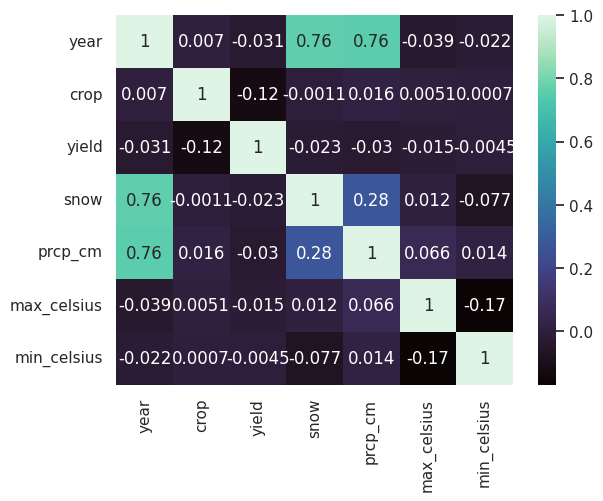

In [ ]:
cat_col = datacorr.select_dtypes(include = ['object']).columns.tolist()
label_encoder = LabelEncoder()

for col in cat_col :
    datacorr[col] = label_encoder.fit_transform(datacorr[col])

# Confusion Matrix
cm = sns.heatmap(datacorr.corr(), annot = True, cmap = 'mako')
plt.show()

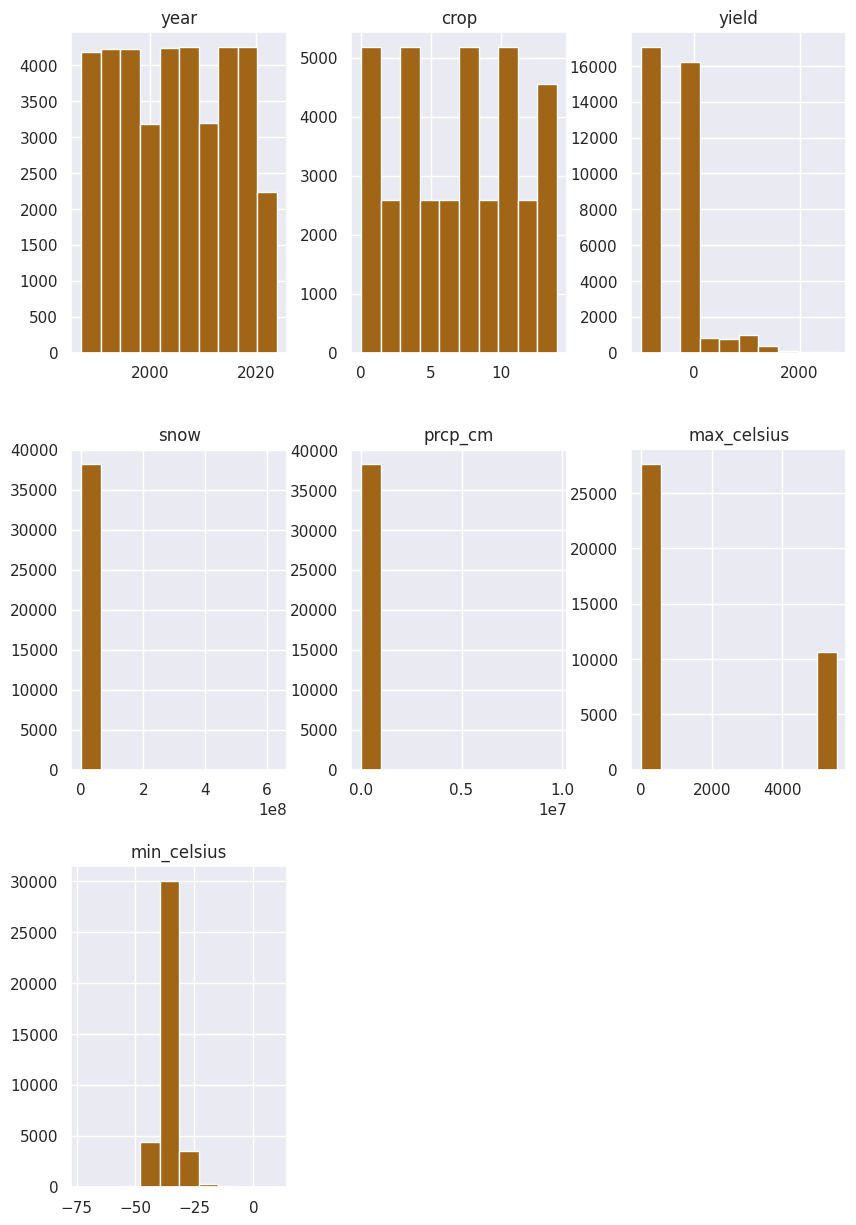

In [ ]:
sns.set(palette='BrBG')
datacorr.hist(figsize=(10,15));

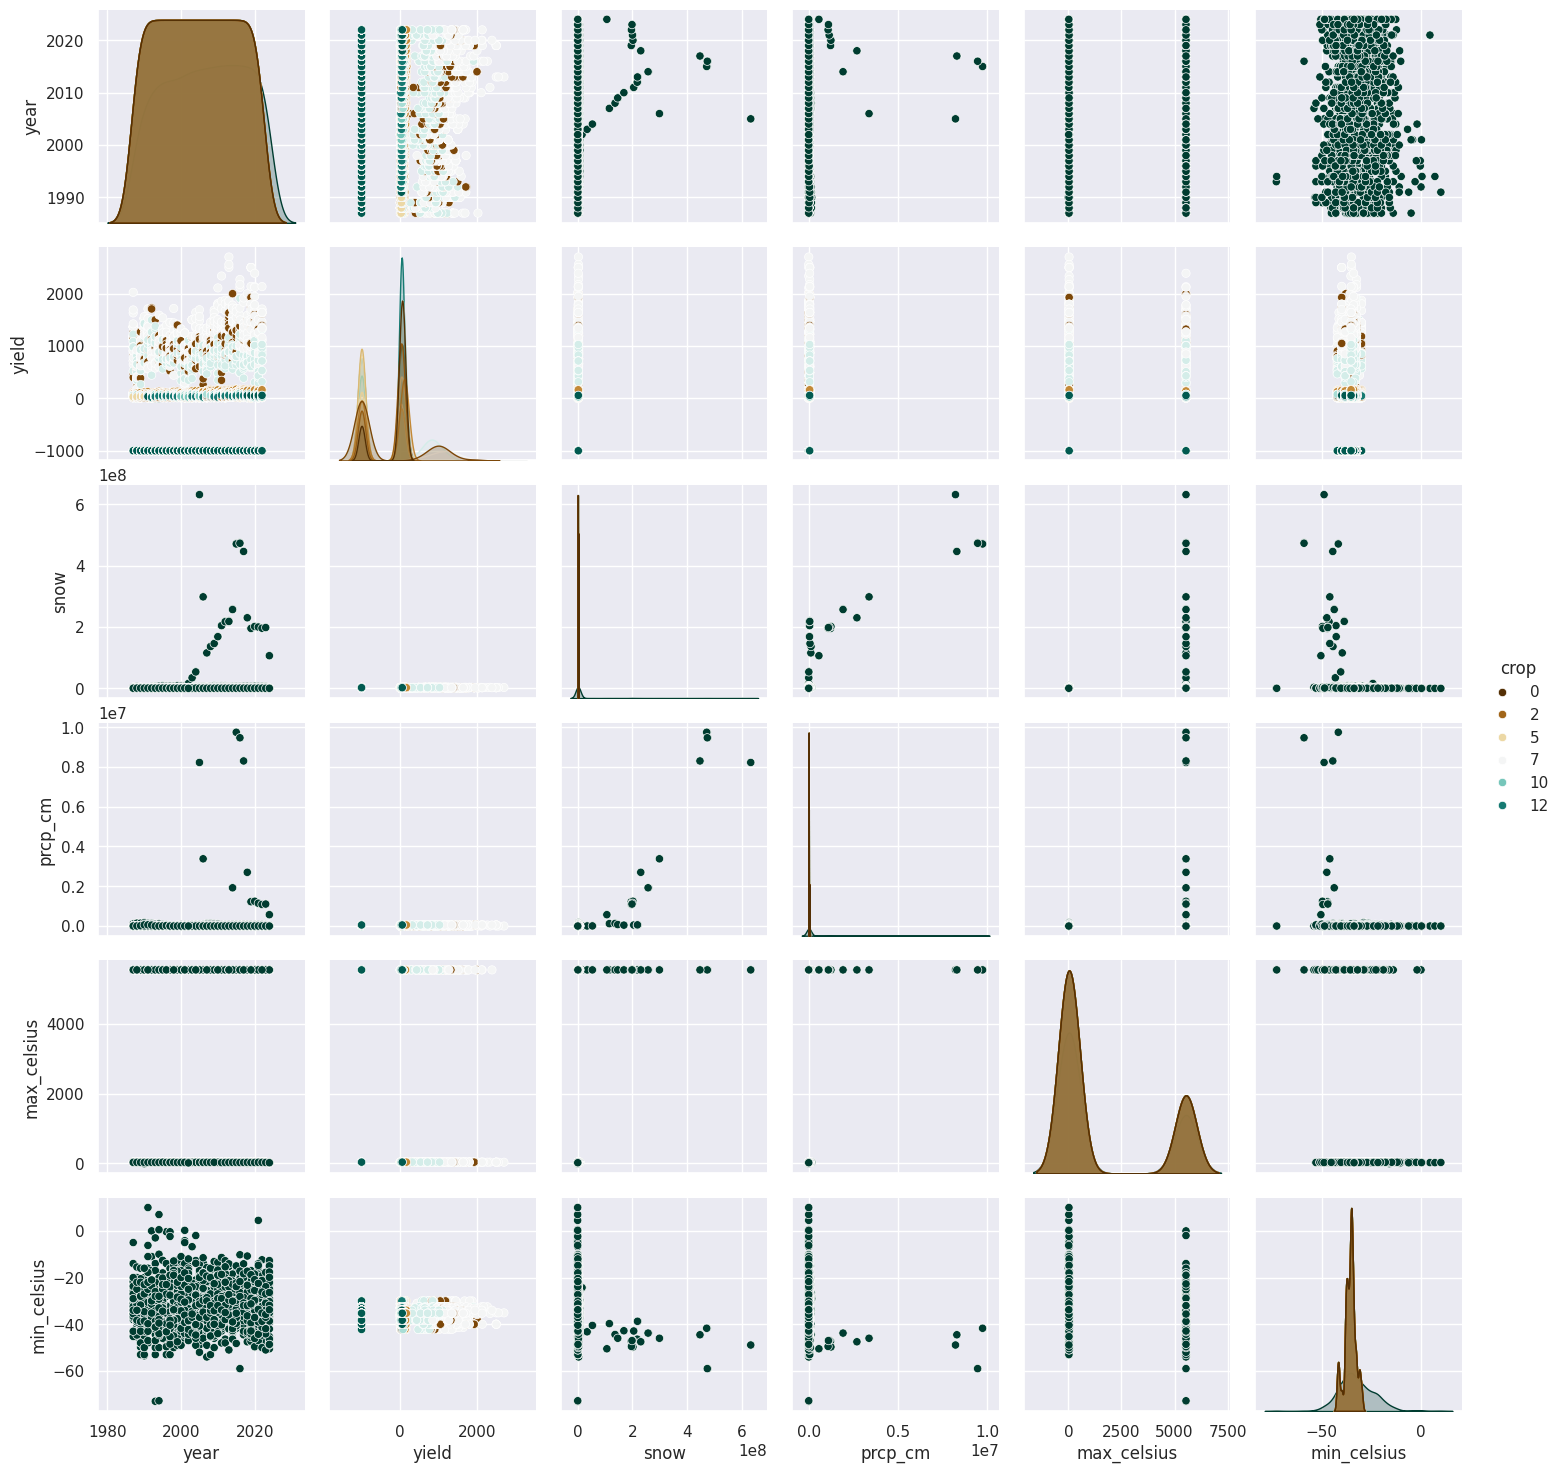

In [ ]:
sns.pairplot(data=datacorr,hue='crop',kind='scatter',palette='BrBG')

# Machine Learning Model building and evaluation

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor

In [ ]:
x, y = datacorr.drop(labels = 'yield', axis = 1), datacorr['yield']

In [ ]:
# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)

In [ ]:
results = []

# List of machine learning models that will be trained
models = [
    ('Linear Regression', LinearRegression()),
    ('Decision Tree', DecisionTreeRegressor(random_state = 1)),
    ('Random Forest', RandomForestRegressor(random_state = 1)),
    ('Gradient Boost', GradientBoostingRegressor(n_estimators = 100, learning_rate = 0.1, max_depth = 3, random_state = 1)),
    ('XGBoost', XGBRegressor(random_state = 1)),
    ('Bagging Regressor', BaggingRegressor(n_estimators = 100, random_state = 1)),
    ('KNN', KNeighborsRegressor(n_neighbors = 10))]

Accuracy of Linear Regression Model Train is 1.60
Accuracy of the Linear Regression Model Test is 1.70


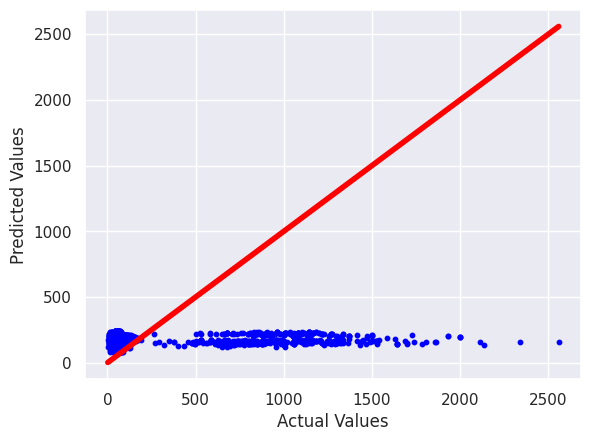

Accuracy of Decision Tree Model Train is 95.17
Accuracy of the Decision Tree Model Test is 95.16


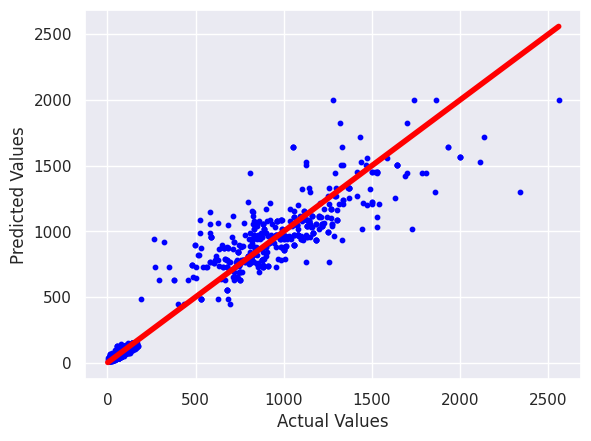

Accuracy of Random Forest Model Train is 95.16
Accuracy of the Random Forest Model Test is 95.14


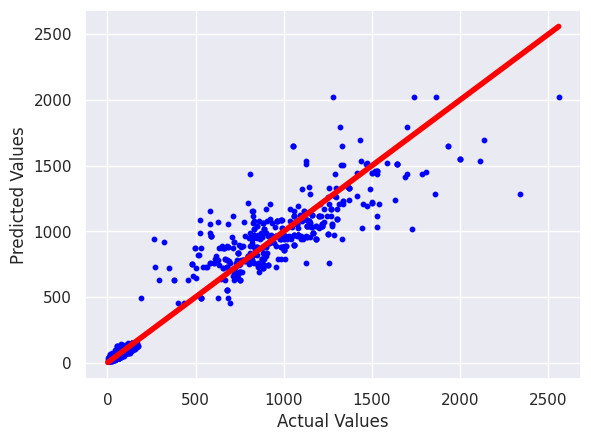

Accuracy of Gradient Boost Model Train is 92.80
Accuracy of the Gradient Boost Model Test is 92.67


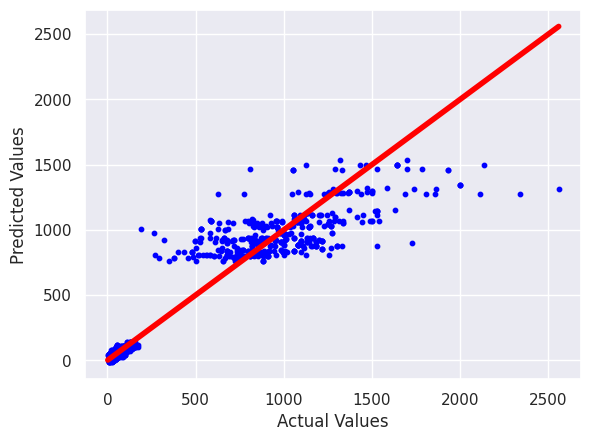

Accuracy of XGBoost Model Train is 95.17
Accuracy of the XGBoost Model Test is 95.17


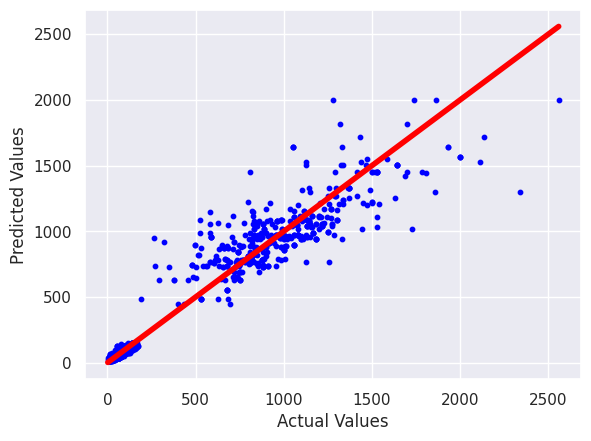

Accuracy of Bagging Regressor Model Train is 95.16
Accuracy of the Bagging Regressor Model Test is 95.14


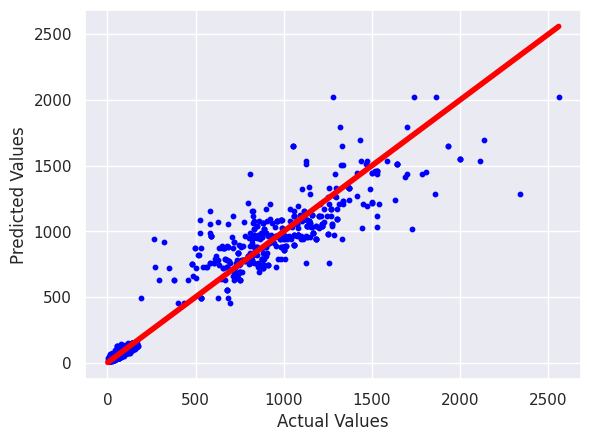

Accuracy of KNN Model Train is 93.86
Accuracy of the KNN Model Test is 93.17


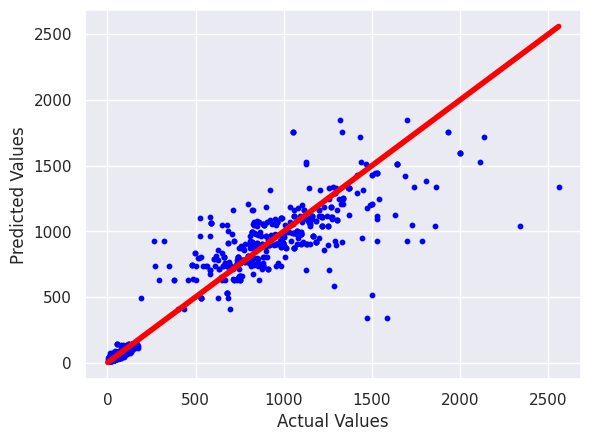

In [ ]:
# Loops through the list of machine learning models above
for name, model in models :
    # Train Model
    model.fit(x_train, y_train)
    # Make Predictions
    y_pred = model.predict(x_test)

    accuracy = model.score(x_test, y_test)
    MSE = mean_squared_error(y_test, y_pred)
    R2_score = r2_score(y_test, y_pred)
    # Add all metrics of model to a list
    results.append((name, accuracy, MSE, R2_score))

    acc = (model.score(x_train , y_train) * 100)
    print(f'Accuracy of {name} Model Train is {acc:.2f}')
    acc = (model.score(x_test , y_test) * 100)
    print(f'Accuracy of the {name} Model Test is {acc:.2f}')

    plt.scatter(y_test, y_pred,s=10,color='blue')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
#     plt.title(f' {name} Evaluation')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth = 4)
    plt.show()

# Comparing Models

In [ ]:
# Dataframe consisting of metrics of all the models
results_df = pd.DataFrame(results, columns = ['Model', 'Accuracy', 'MSE', 'R2_score'])
# Add red and green highlights in the dataframe to display best and worst performing models
results_format_df = results_df.style.highlight_max(subset = ['Accuracy', 'R2_score'], color = 'green').highlight_min(subset = ['MSE'], color = 'green').highlight_max(subset = ['MSE'], color = 'red').highlight_min(subset = ['Accuracy','R2_score'], color = 'red')
display(results_format_df)

,Model,Accuracy,MSE,R2_score
0,Linear Regression,0.016984,105814.234857,0.016984
1,Decision Tree,0.951628,5206.850143,0.951628
2,Random Forest,0.951397,5231.752570,0.951397
3,Gradient Boost,0.926664,7894.020481,0.926664
4,XGBoost,0.951659,5203.552788,0.951659
5,Bagging Regressor,0.951397,5231.771827,0.951397
6,KNN,0.931721,7349.690142,0.931721


# K-Fold Cross Validation

In [ ]:
results = []
fold_df = pd.DataFrame()

# Loops through the list of machine learning models
for name, model in models :
    # Train Model
    model.fit(x_train, y_train)
    # Make Predictions
    y_pred = model.predict(x_test)
    accuracy = model.score(x_test, y_test)
    MSE = mean_squared_error(y_test, y_pred)
    MAE = mean_absolute_error(y_test, y_pred)
    MAPE = mean_absolute_percentage_error(y_test, y_pred)
    R2_score = r2_score(y_test, y_pred)
    # Add all metrics of model to a list
    results.append((name, accuracy, MSE, MAE, MAPE, R2_score))

    print(name)
    kf = KFold(n_splits = 10, shuffle = True)
    scores = cross_val_score(model, x, y, cv = kf)

    # Print out the CV Scores for each fold
    for fold, score in enumerate(scores) :
        print(f'Fold {fold + 1}: {score}')
        temp_df = pd.DataFrame({'Name' : name, 'Fold' : [fold + 1], 'Score' : [score]})
        dfs = [fold_df, temp_df]
        fold_df = pd.concat(dfs, ignore_index = True)

    # Print out the Mean CV scores for each model
    mean_score = np.mean(scores)
    print(f'Mean Score: {mean_score}')
    print('=' * 30)

Linear Regression
Fold 1: 0.01257882712842262
Fold 2: 0.004870802466318325
Fold 3: 0.006986390720256863
Fold 4: 0.02855507683831693
Fold 5: 0.01979475715056611
Fold 6: 0.013122044466549965
Fold 7: 0.017796333885880422
Fold 8: 0.01751179519644608
Fold 9: 0.019556626135206256
Fold 10: 0.00925032587931407
Mean Score: 0.015002297986727763
Decision Tree
Fold 1: 0.946026956855764
Fold 2: 0.9444064686318793
Fold 3: 0.9333170329788678
Fold 4: 0.9415174066543708
Fold 5: 0.9572665557535629
Fold 6: 0.9449540119505616
Fold 7: 0.9445530563686939
Fold 8: 0.9494328139390839
Fold 9: 0.9561450923461092
Fold 10: 0.9509709633012196
Mean Score: 0.9468590358780112
Random Forest
Fold 1: 0.9479318368367742
Fold 2: 0.9425250326202435
Fold 3: 0.947438561118902
Fold 4: 0.9483032929259889
Fold 5: 0.9449882085507557
Fold 6: 0.9610964364599057
Fold 7: 0.950867678690719
Fold 8: 0.9441306782835217
Fold 9: 0.9383997598395077
Fold 10: 0.9426664186039404
Mean Score: 0.9468347903930259
Gradient Boost
Fold 1: 0.920087758

In [ ]:
for i in range(1, 8) :
    plot_fold_df = fold_df.iloc[i * 10 - 10 : i * 10]

    fig = go.Figure()

    fig.add_trace(go.Scatter(x = plot_fold_df['Fold'],
                             y = plot_fold_df['Score'],
                             mode = 'lines+markers',
                             name = 'Accuracy'))

    fig.update_layout(title = {'text' : plot_fold_df['Name'].iloc[i],
                       'xanchor' : 'center',
                       'yanchor' : 'top',
                       'x' : 0.5},
                       xaxis_title = 'Fold',
                       yaxis_title = 'Score',
                       title_font = dict(size = 20))

    fig.layout.template = 'plotly_dark'

    fig.show()

# Comparing Models

In [ ]:
# Dataframe consisting of metrics of all the models
result_df = pd.DataFrame(results, columns = ['Model', 'Accuracy', 'MSE', 'MAE', 'MAPE', 'R2_score'])
# Add red and green highlights in the dataframe to display best and worst performing models
result_format_df = result_df.style.highlight_max(subset = ['Accuracy','R2_score'], color = 'green').highlight_min(subset = ['MSE','MAE','MAPE'], color = 'green').highlight_max(subset = ['MSE','MAE','MAPE'], color = 'red').highlight_min(subset = ['Accuracy','R2_score'], color = 'red')
display(result_format_df)

,Model,Accuracy,MSE,MAE,MAPE,R2_score
0,Linear Regression,0.016984,105814.234857,195.494104,2.822312,0.016984
1,Decision Tree,0.951628,5206.850143,25.704605,0.207631,0.951628
2,Random Forest,0.951397,5231.752570,25.697224,0.207604,0.951397
3,Gradient Boost,0.926664,7894.020481,33.089373,0.313742,0.926664
4,XGBoost,0.951659,5203.552788,25.699480,0.207535,0.951659
5,Bagging Regressor,0.951397,5231.771827,25.697222,0.207604,0.951397
6,KNN,0.931721,7349.690142,27.600096,0.213337,0.931721
